In [9]:
'''This notebook is the code for developing the clusters for patient journeys described in the paper:
Using Natural Language Processing and Patient Journey Clustering for Temporal Phenotyping of 
Antimicrobial Therapies for Cat Bite Abscesses. The example uses case journey sequences formatted into letter
strings that can be created using '''

import pandas as pd
import re
import pandas as pd


class CFG:
    FILE_PATH='./patient_journeys.csv' # Update with your file path to appropriate path if necessary
    MIN_COUNT=10 #number of minimum occurances to include for each specific event
    MIN_SEQUENCE=3 #minimum sequence length of strings


df = pd.read_csv(CFG.FILE_PATH, index_col=0)



In [10]:
'''create weights for levenshtein distance calculations'''

import string
import numpy as np
import sys
from weighted_levenshtein import lev, osa, dam_lev

ABX = 'cdghklop'
SX = 'efghmnop'

#modifying edit weights

insert_costs = np.ones(128, dtype=np.float64)
delete_costs = np.ones(128, dtype=np.float64)
transpose_costs = np.ones((128, 128), dtype=np.float64)
substitute_costs = np.ones((128, 128), dtype=np.float64) 

# make an array of all 1's of size 128, the number of ASCII characters
insert_costs[ord('x')] = 0.1  # make inserting the character 'x' have cost 0.1 (instead of 1)
transpose_costs[ord('x')] = 0.1
delete_costs[ord('x')] = 0.1


abx_difference = ''.join(list(set(SX).difference(ABX)))
sx_difference = ''.join(list(set(ABX).difference(SX)))
sx_abx_intersection = ''.join(list(set(ABX).intersection(SX)))
# abx_union

#adjust transpose costs
for x in string.ascii_lowercase: 
    transpose_costs[ord('x'), ord(x)] = 0.1
    transpose_costs[ord(x), ord('x')] = 0.1
  
        

#adjust ABX and SX costs for insertion, deletion and substitutions to be higher
for x in string.ascii_lowercase: 
    if x in ABX or x in SX:
        insert_costs[ord(x)] = 5
        delete_costs[ord(x)] = 5
        for i in string.ascii_lowercase:
            substitute_costs[ord(x), ord(i)] = 5
            substitute_costs[ord(i), ord(x)] = 5
            

#adjust substitution costs for alternate records with abx to be lower
for x in abx_difference:
    for i in abx_difference:
        substitute_costs[ord(x), ord(i)] = 0.1
        substitute_costs[ord(i), ord(x)] = 0.1
        
#adjust substitution costs for alternate records with sx to be lower
for x in sx_difference:
    for i in sx_difference:
        substitute_costs[ord(x), ord(i)] = 0.1
        substitute_costs[ord(i), ord(x)] = 0.1

for x in sx_abx_intersection:
    for i in sx_abx_intersection:
        substitute_costs[ord(x), ord(i)] = 0.1
        substitute_costs[ord(i), ord(x)] = 0.1


# substitute_costs = np.ones((128, 128), dtype=np.float64)  # make a 2D array of 1's
# substitute_costs[ord('H'), ord('B')] = 1.25  # make substituting 'H' for 'B' cost 1.25        
# transpose_costs[ord('A'), ord('B')] = 0.75  # make swapping 'A' for 'B' cost 0.75



In [11]:
def lev_similarity(base_words_list, test_words):
    base_words = np.asarray(base_words_list)
    new_words = np.asarray(test_words)
    return -1*np.array([[osa(w1,w2, transpose_costs=transpose_costs, delete_costs=delete_costs, insert_costs=insert_costs, substitute_costs=substitute_costs) for w1 in base_words] for w2 in test_words])


For n_clusters = 2 The average silhouette_score is : 0.5052238319143166
For n_clusters = 3 The average silhouette_score is : 0.5838580300015284
For n_clusters = 4 The average silhouette_score is : 0.6723128892728946
For n_clusters = 5 The average silhouette_score is : 0.7498168404637103
For n_clusters = 6 The average silhouette_score is : 0.7995123588449605
For n_clusters = 7 The average silhouette_score is : 0.8361799526419404
For n_clusters = 8 The average silhouette_score is : 0.8524489969112935
For n_clusters = 9 The average silhouette_score is : 0.8715010202278879
For n_clusters = 10 The average silhouette_score is : 0.8414890785674618
For n_clusters = 11 The average silhouette_score is : 0.8924139260213368
For n_clusters = 12 The average silhouette_score is : 0.7854930757546496
For n_clusters = 13 The average silhouette_score is : 0.6844102992199992
For n_clusters = 14 The average silhouette_score is : 0.6293956594171816
For n_clusters = 15 The average silhouette_score is : 0.629

<ipython-input-12-eb9e65dff591>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


For n_clusters = 24 The average silhouette_score is : 0.38214070969388436
For n_clusters = 25 The average silhouette_score is : 0.34204816131637644
For n_clusters = 26 The average silhouette_score is : 0.3361611630631742
For n_clusters = 27 The average silhouette_score is : 0.3340191078033081
For n_clusters = 28 The average silhouette_score is : 0.3199252229041862
For n_clusters = 29 The average silhouette_score is : 0.3064423098681969
For n_clusters = 30 The average silhouette_score is : 0.26362869440278264
For n_clusters = 31 The average silhouette_score is : 0.24658194391024787
For n_clusters = 32 The average silhouette_score is : 0.2176708667170915
For n_clusters = 33 The average silhouette_score is : 0.18320161296396645
For n_clusters = 34 The average silhouette_score is : 0.17022660217872473
For n_clusters = 35 The average silhouette_score is : 0.13589578214790754
For n_clusters = 36 The average silhouette_score is : 0.11874301155531213
For n_clusters = 37 The average silhouette_

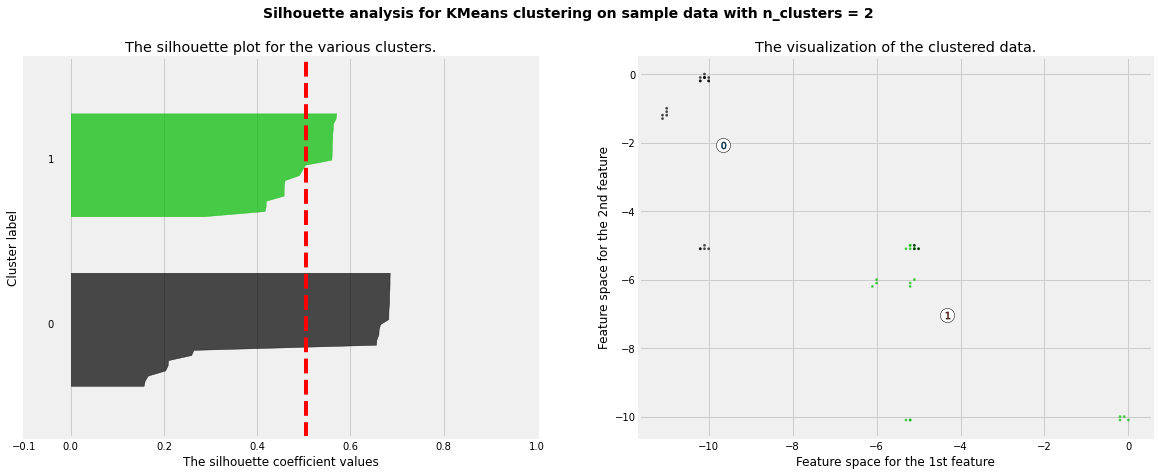

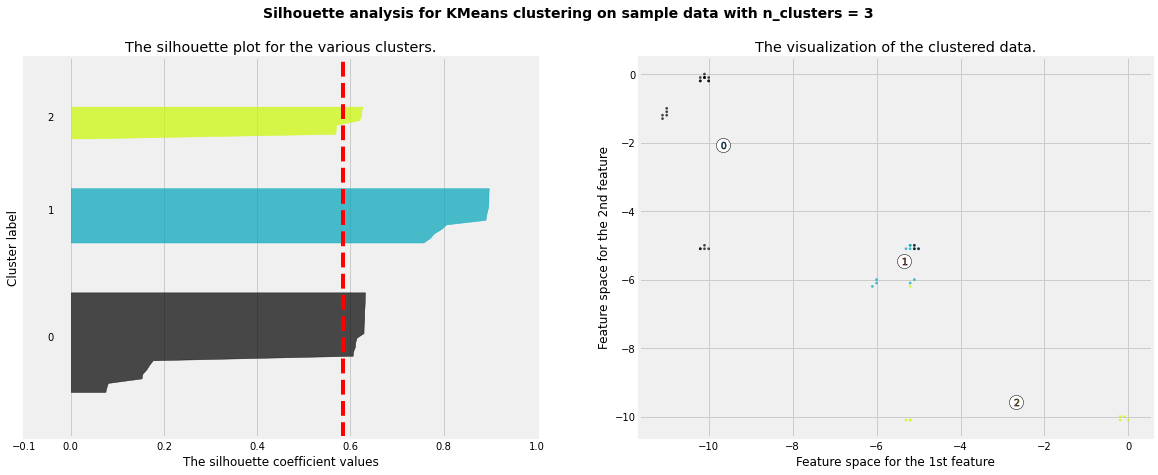

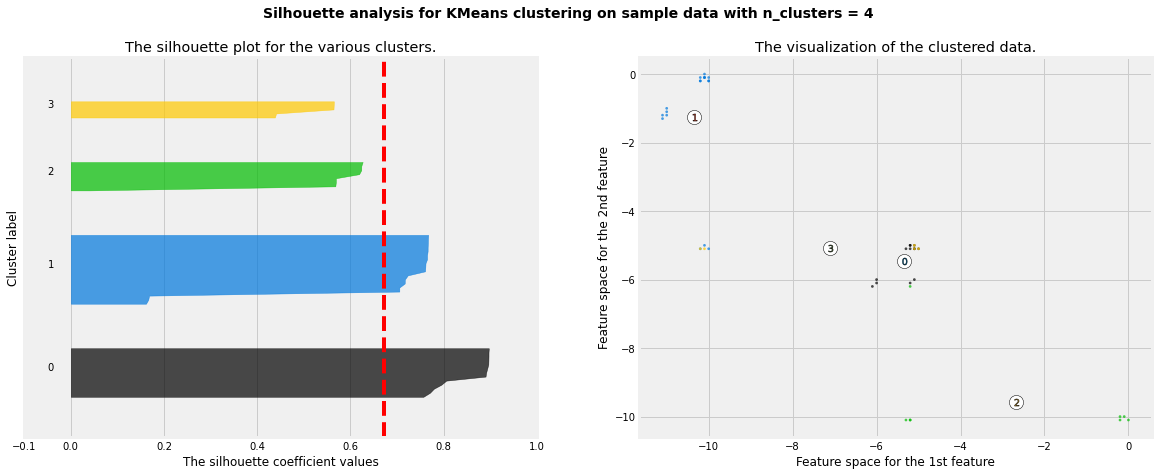

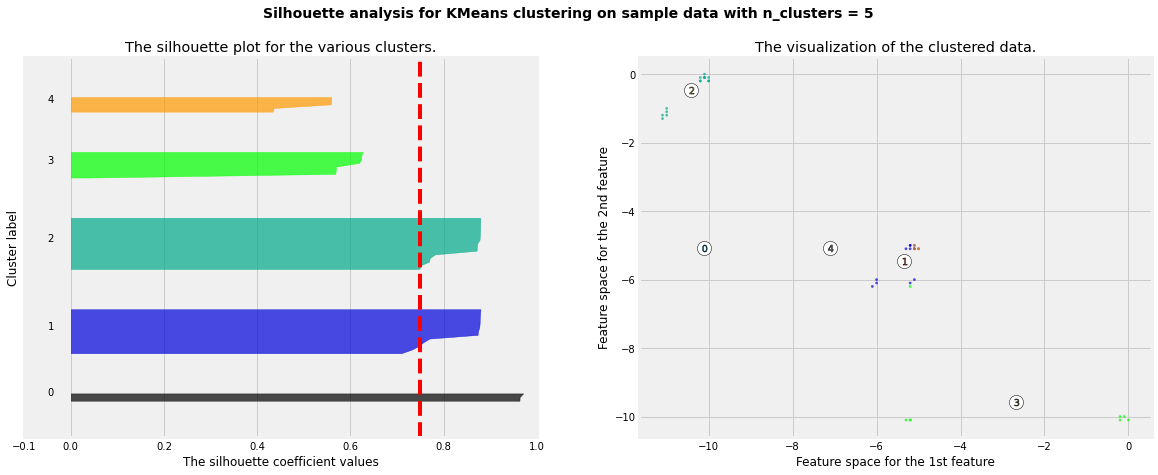

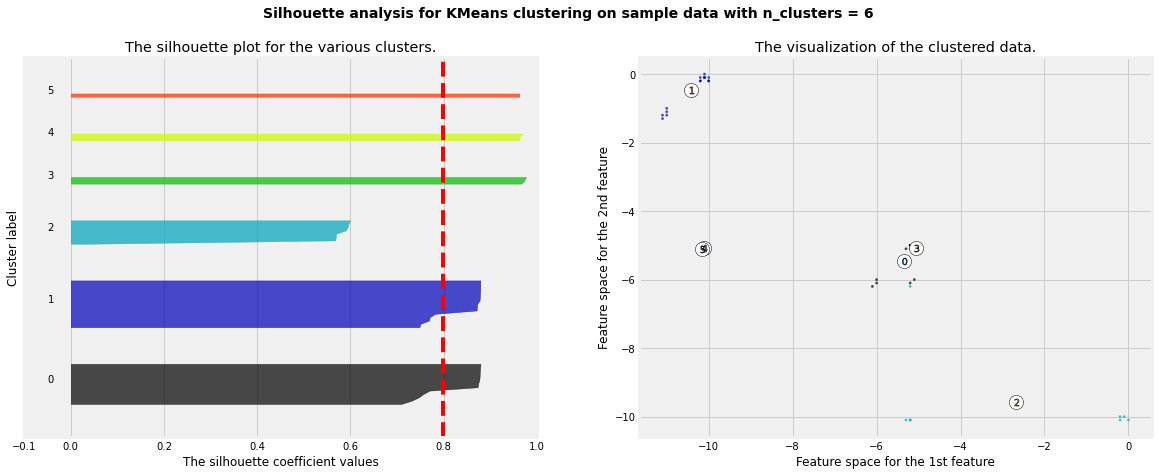

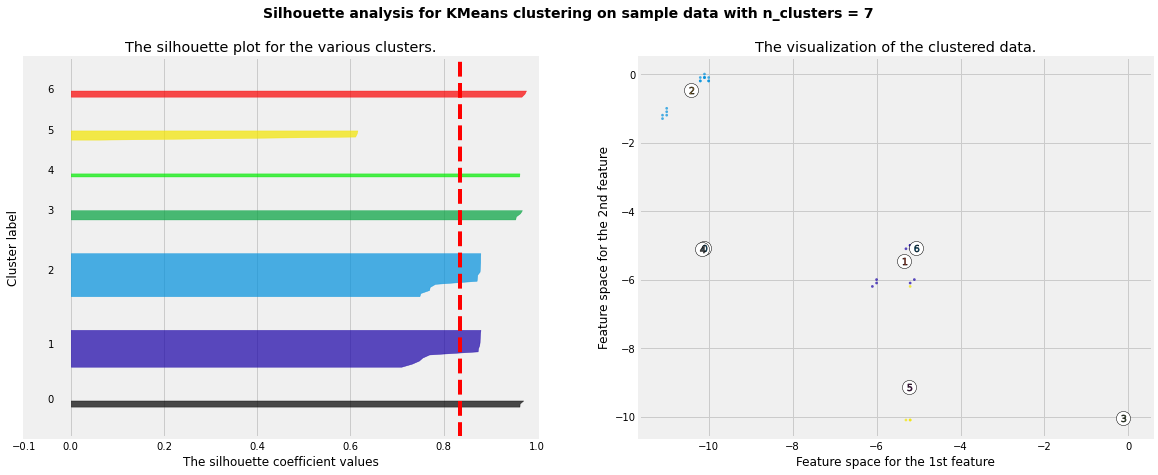

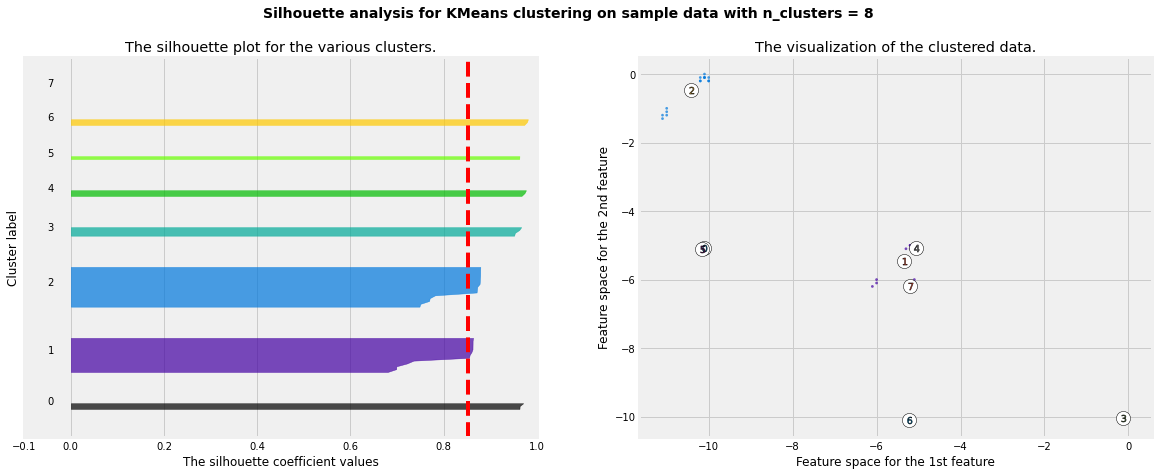

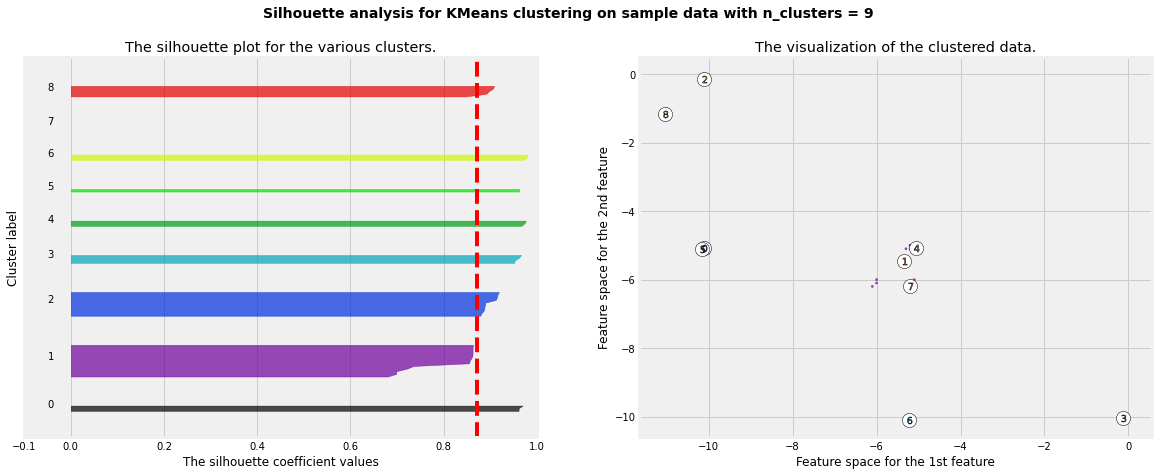

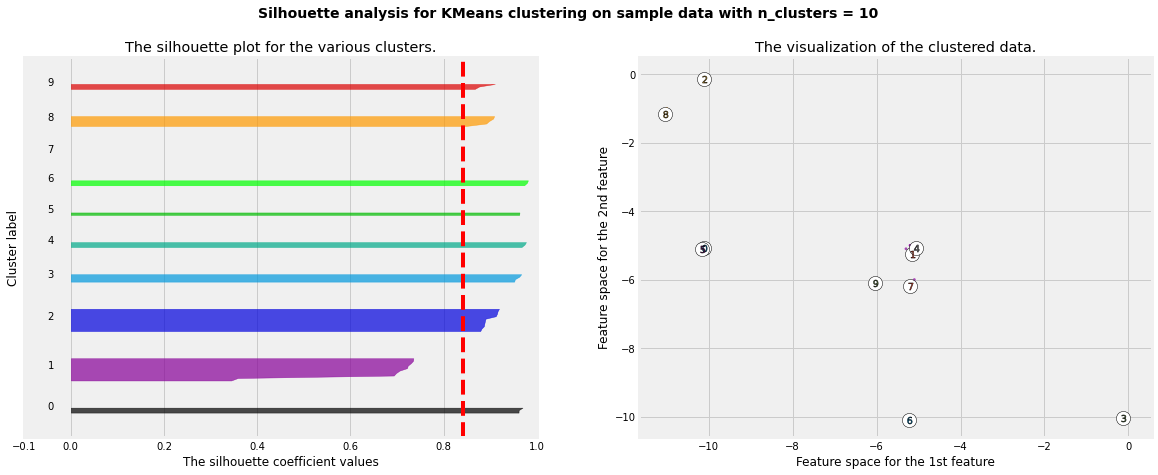

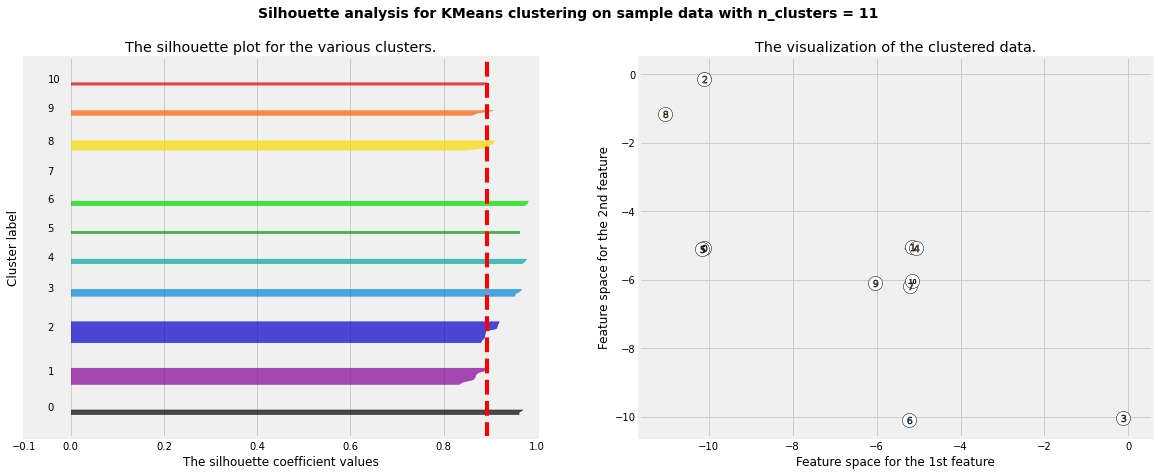

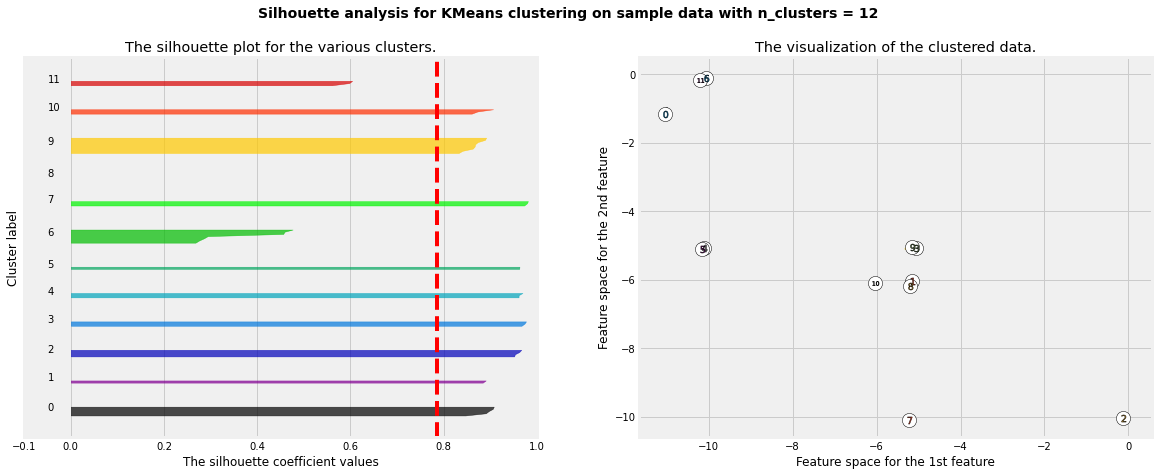

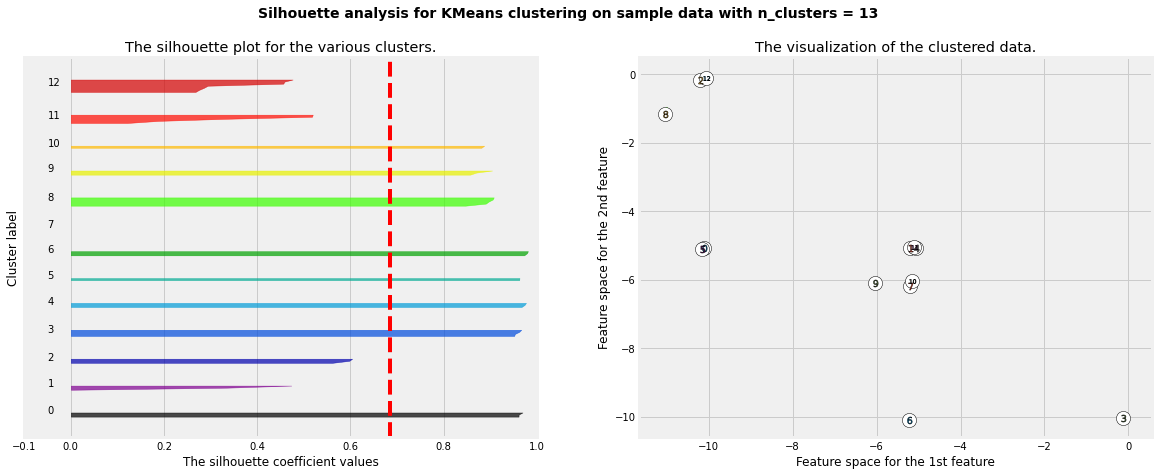

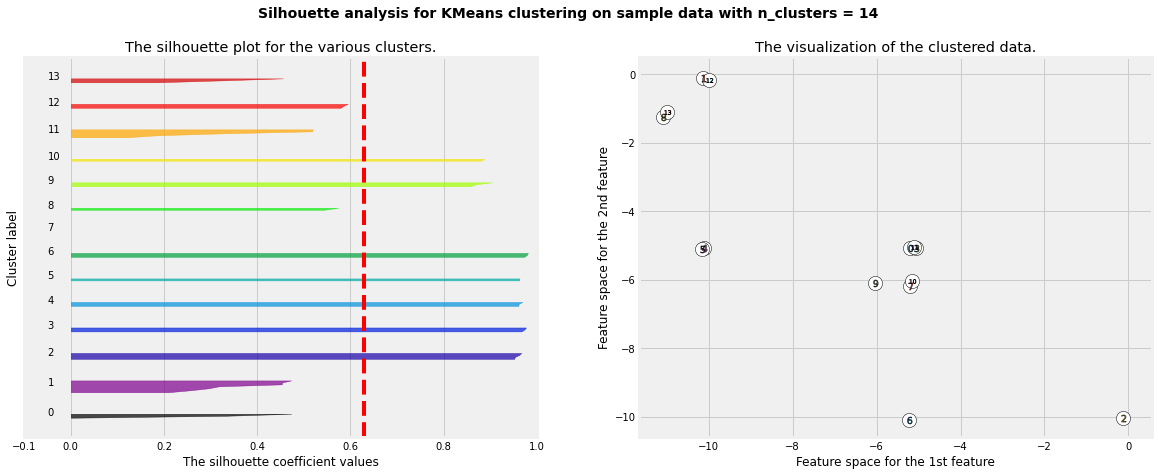

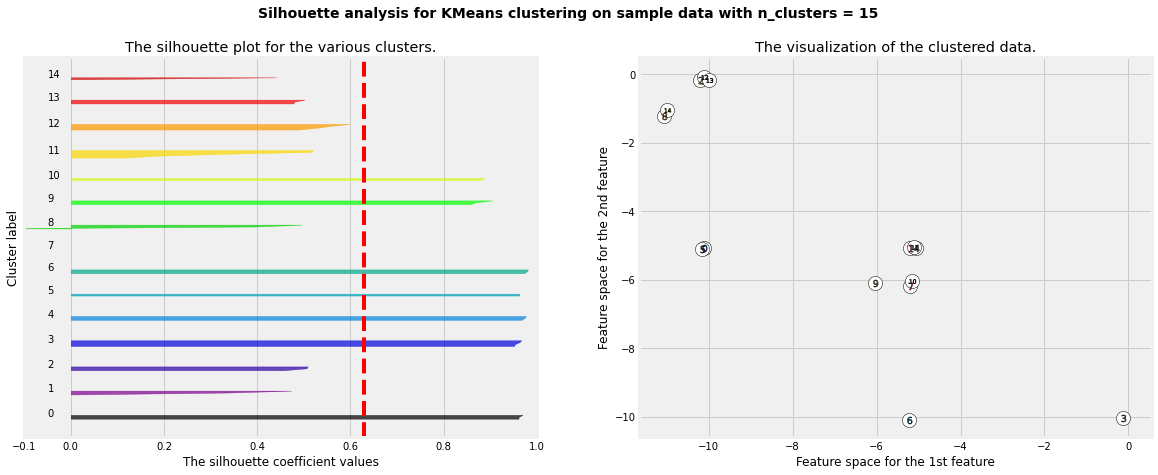

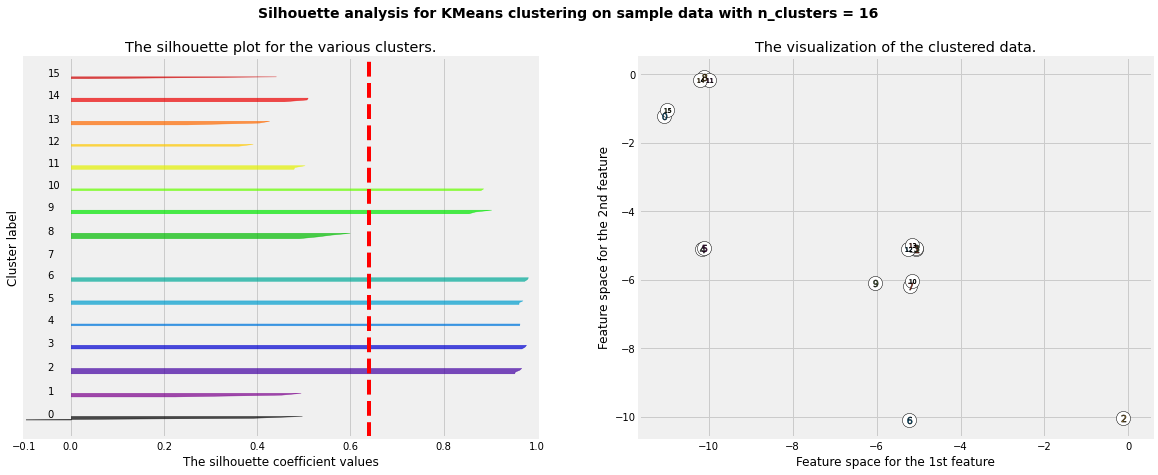

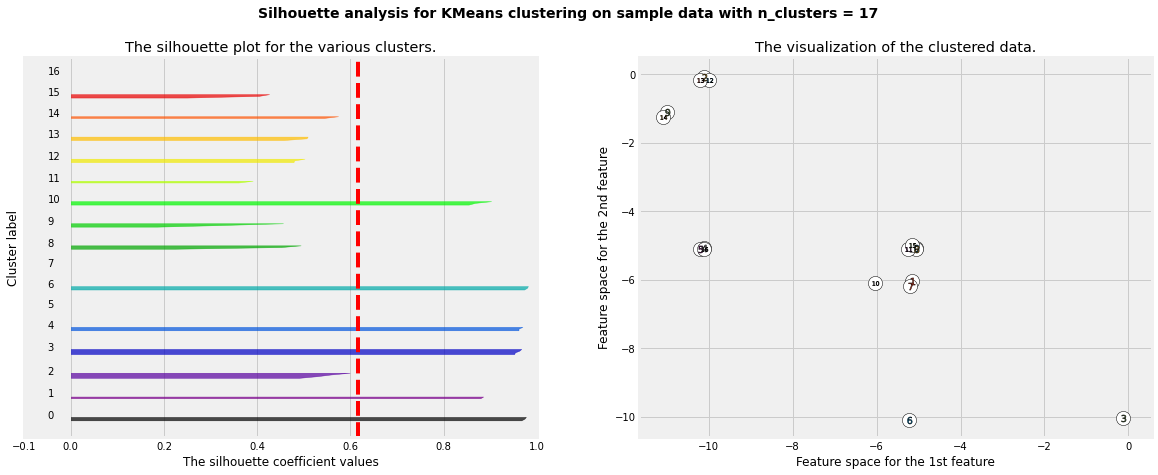

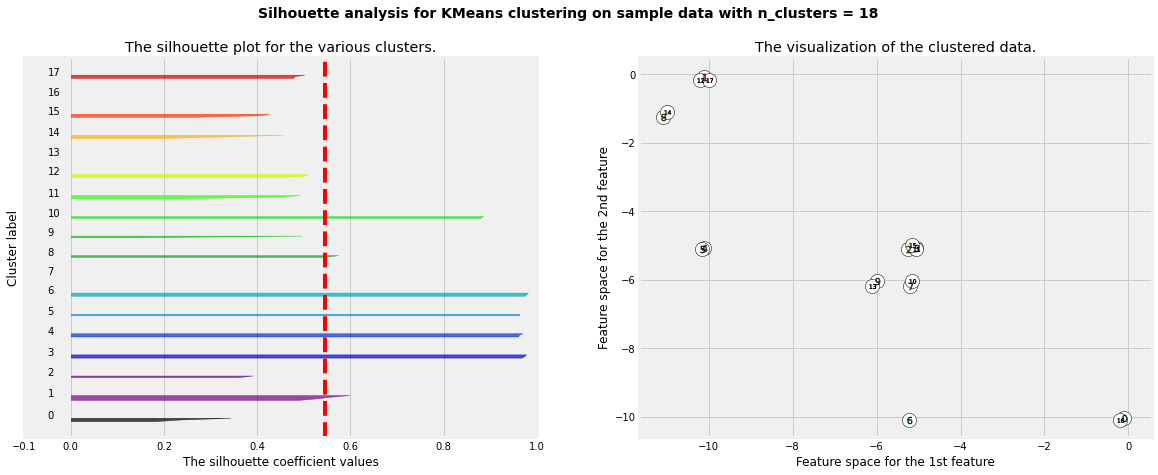

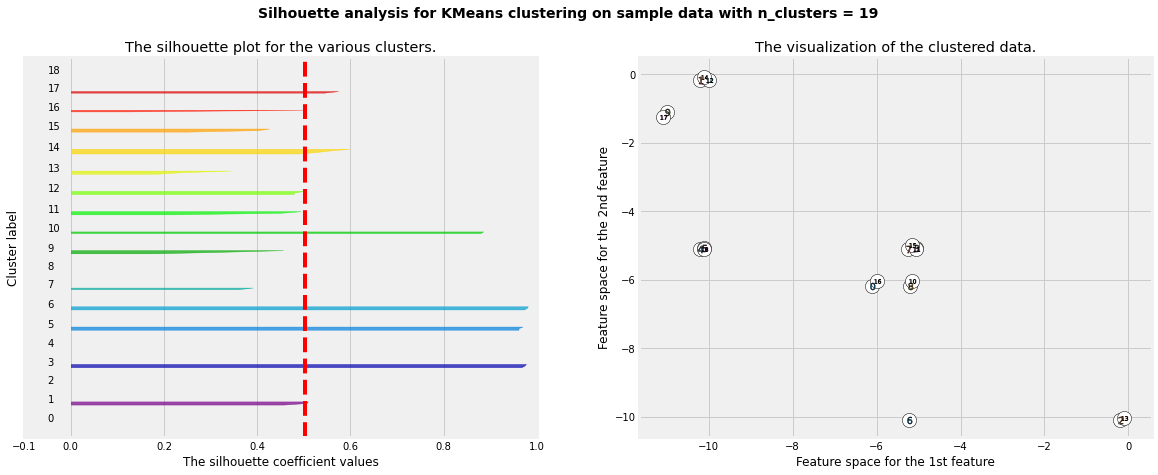

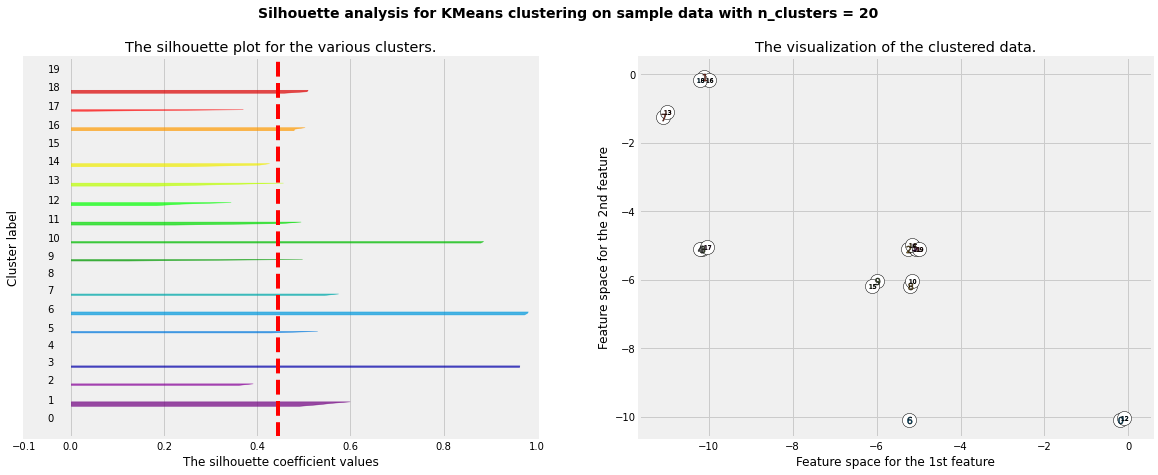

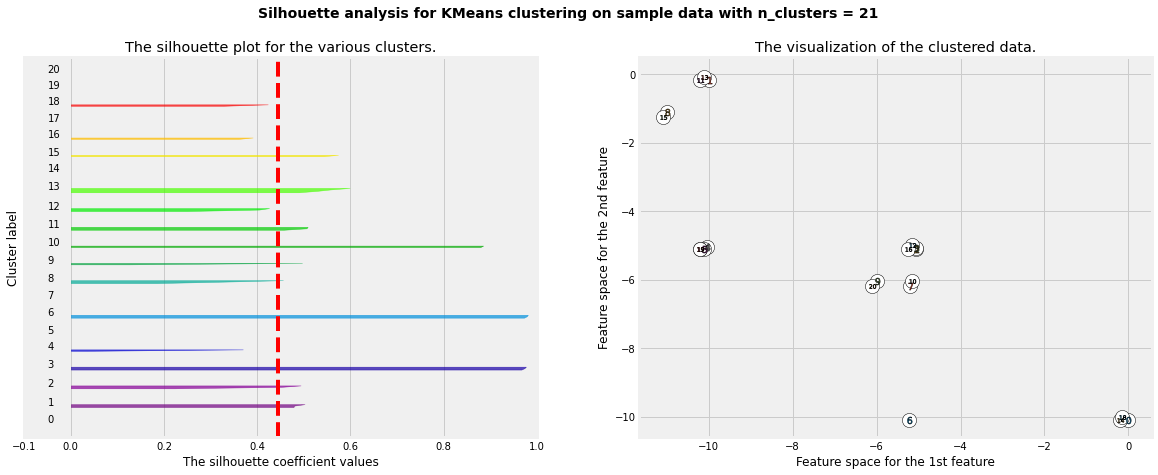

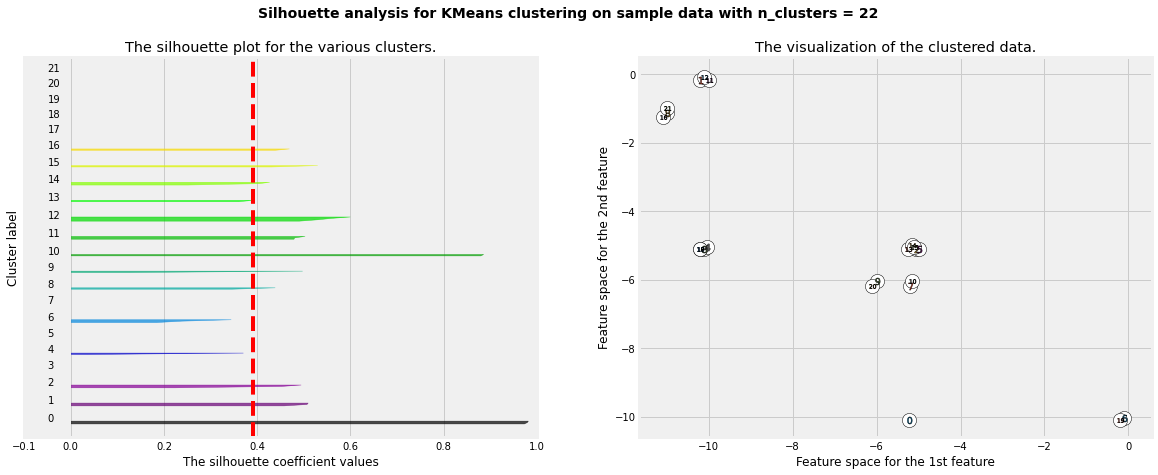

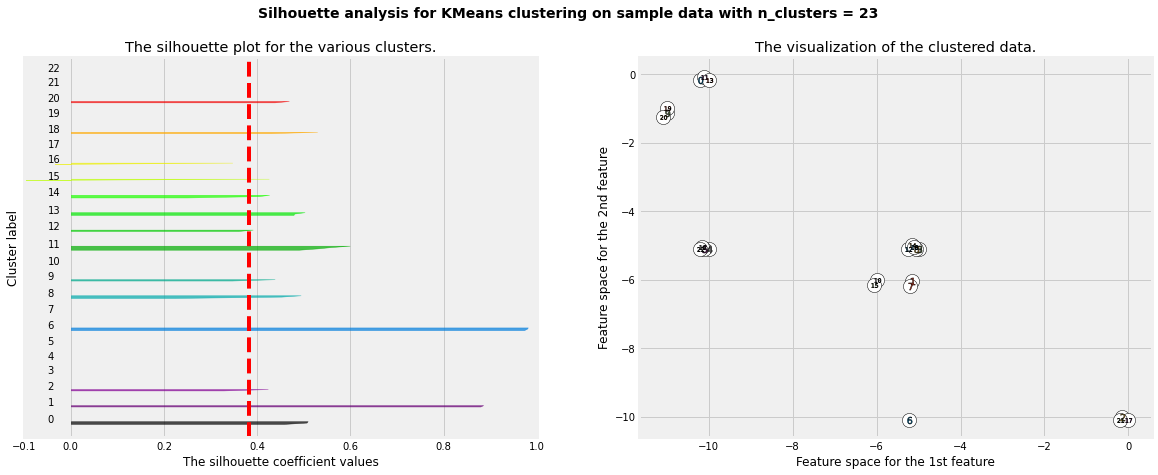

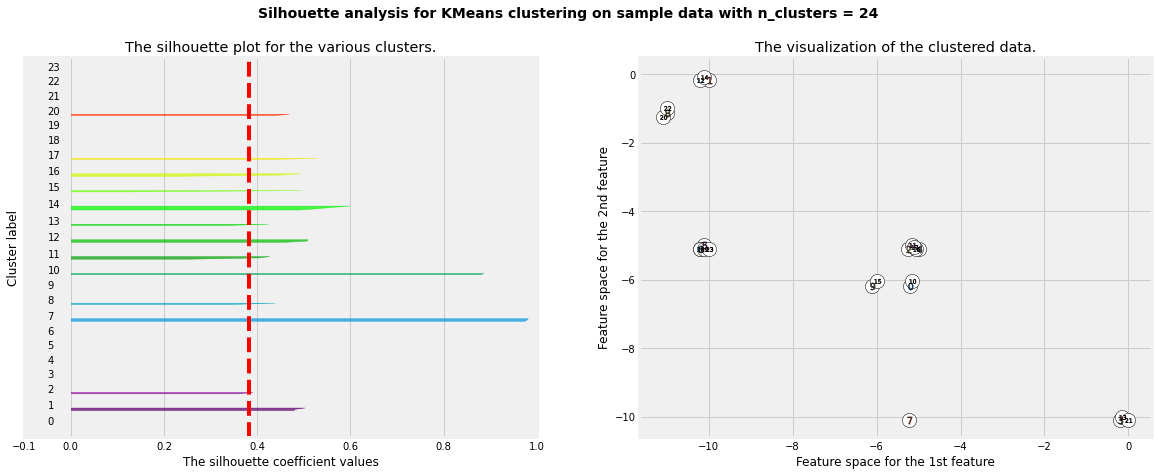

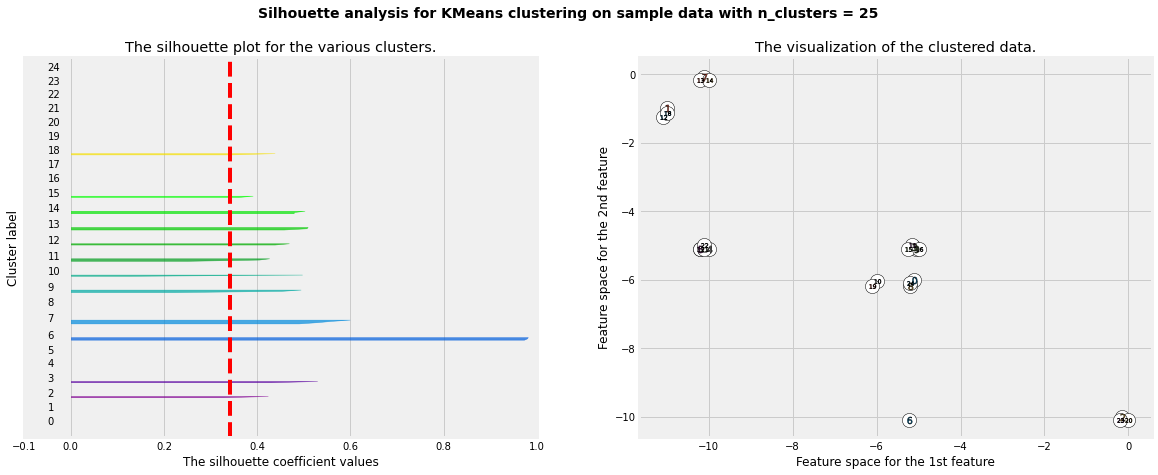

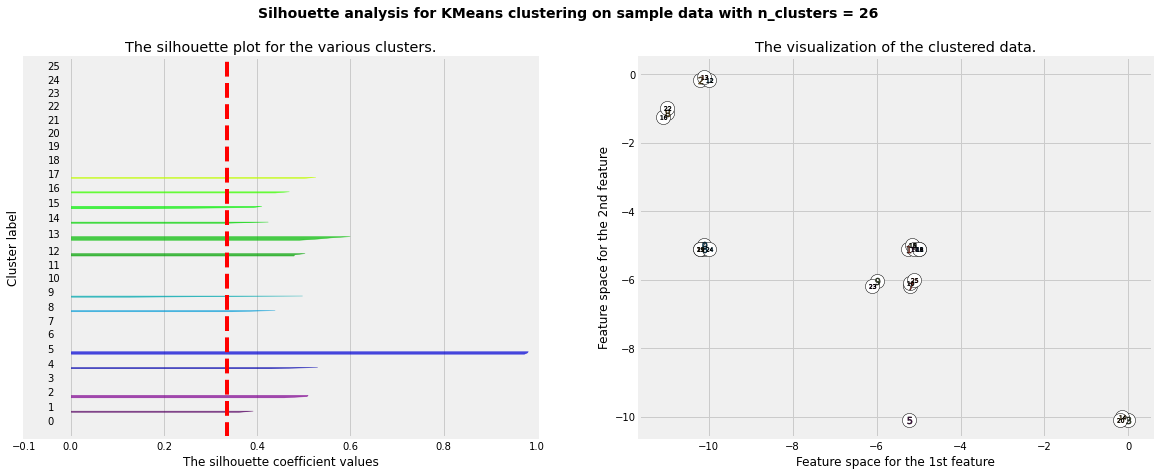

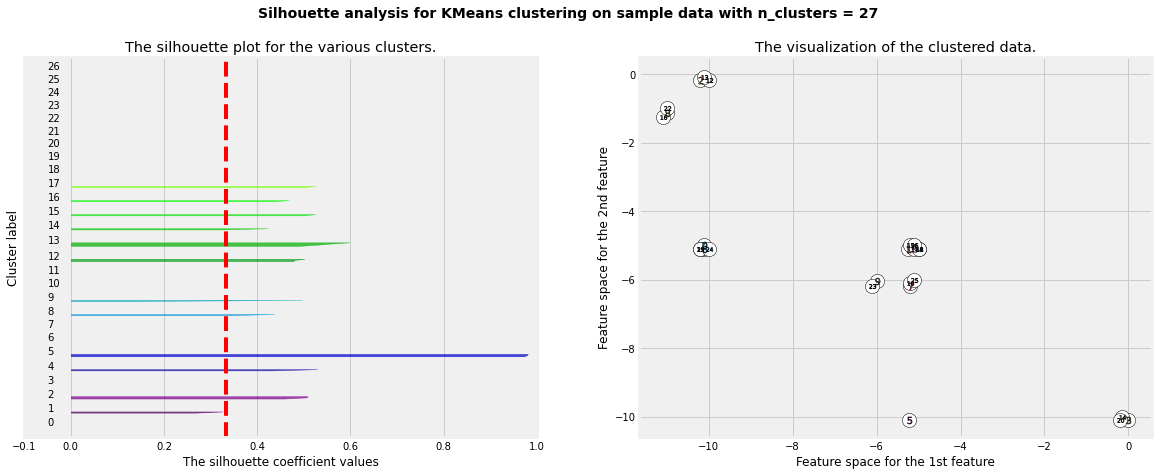

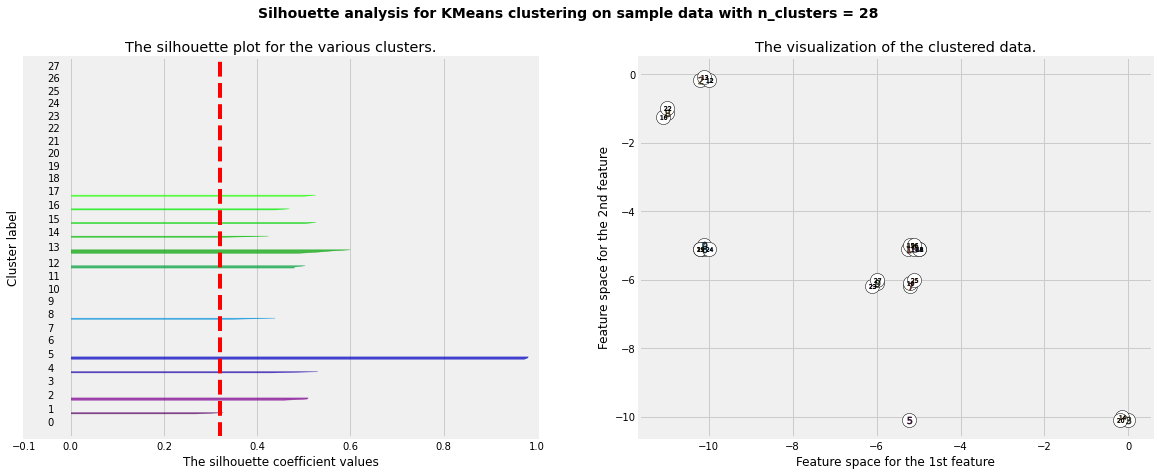

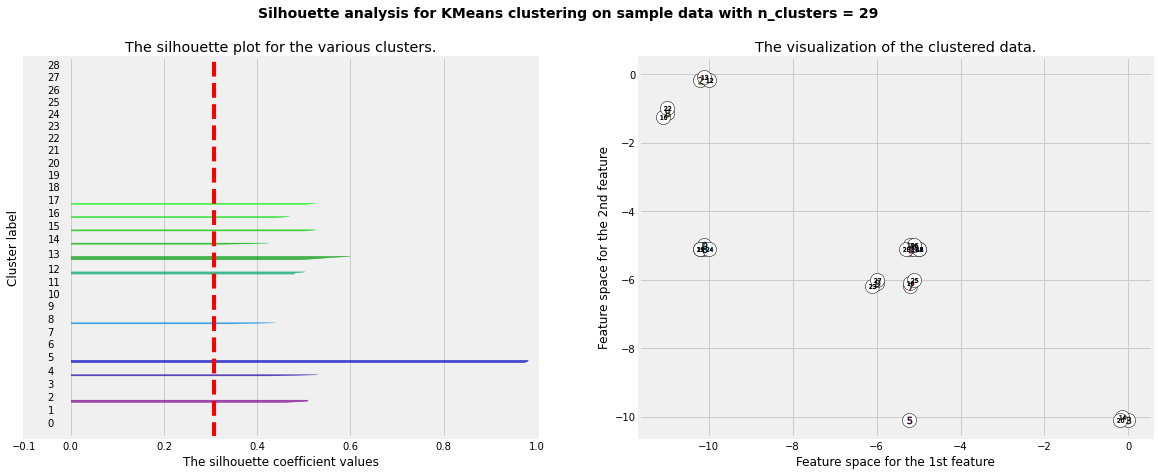

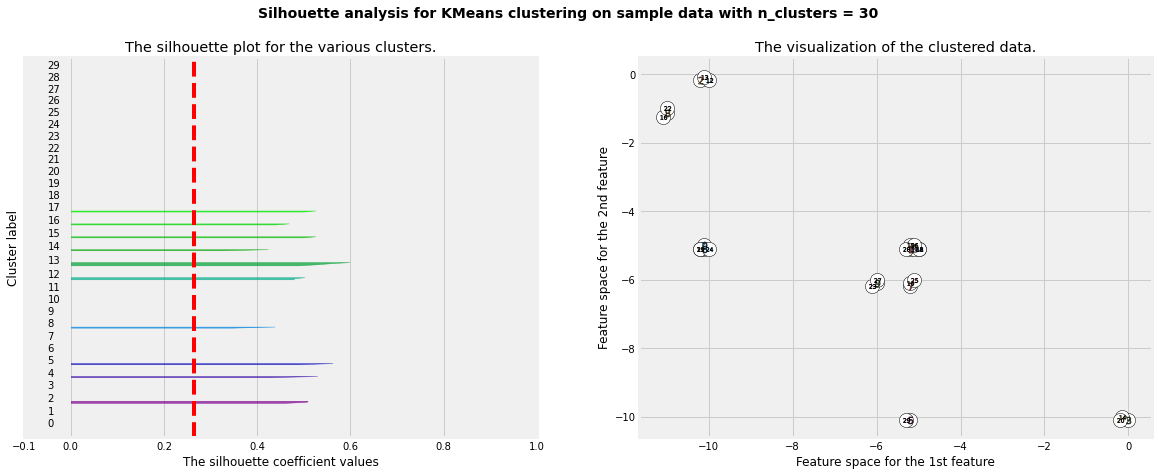

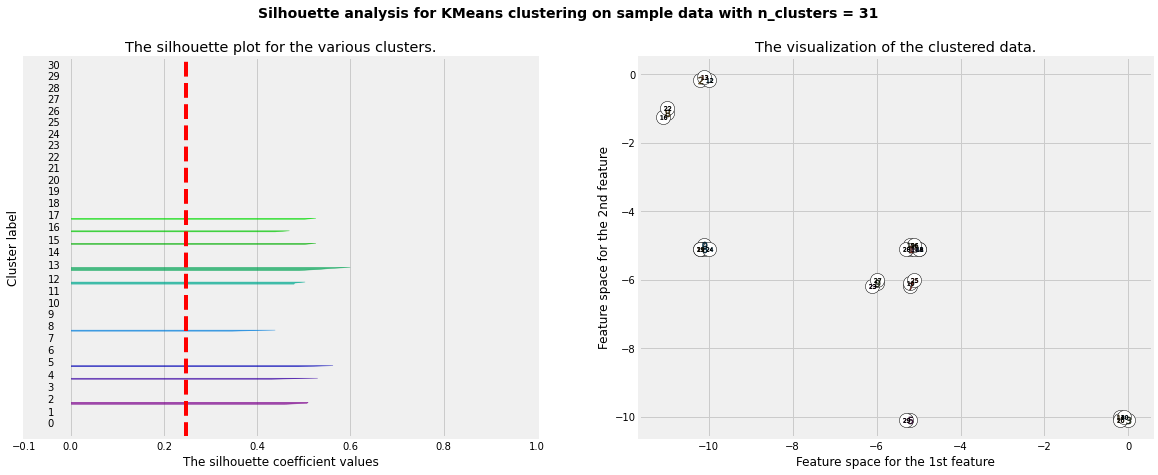

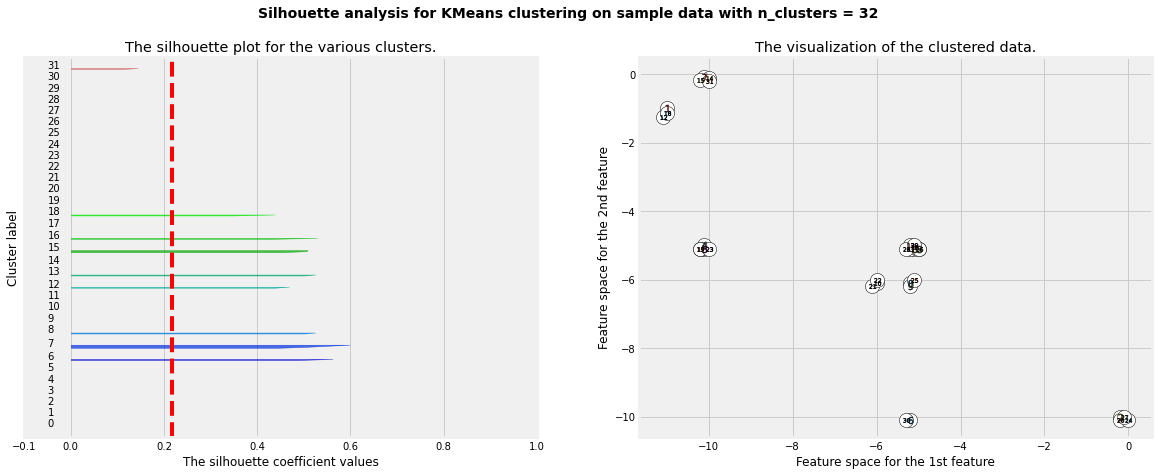

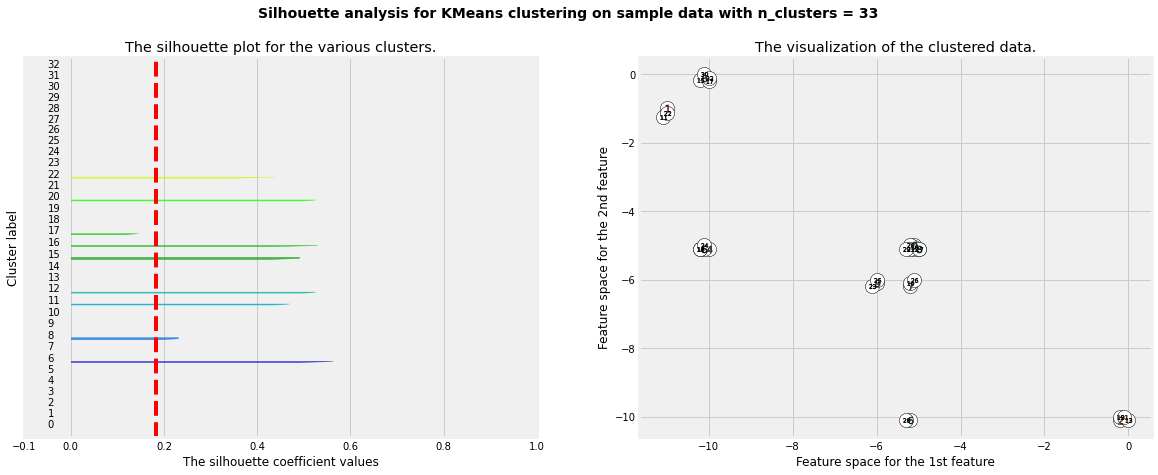

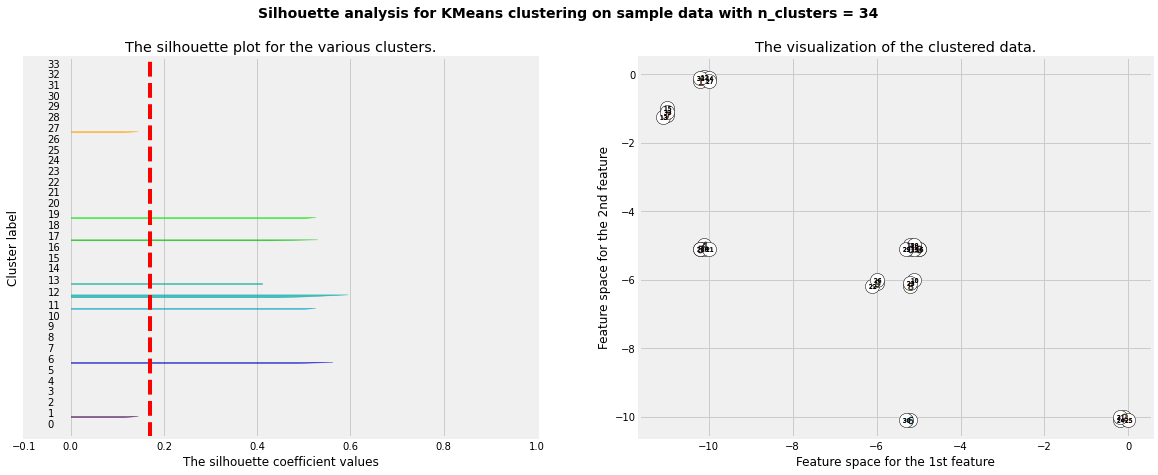

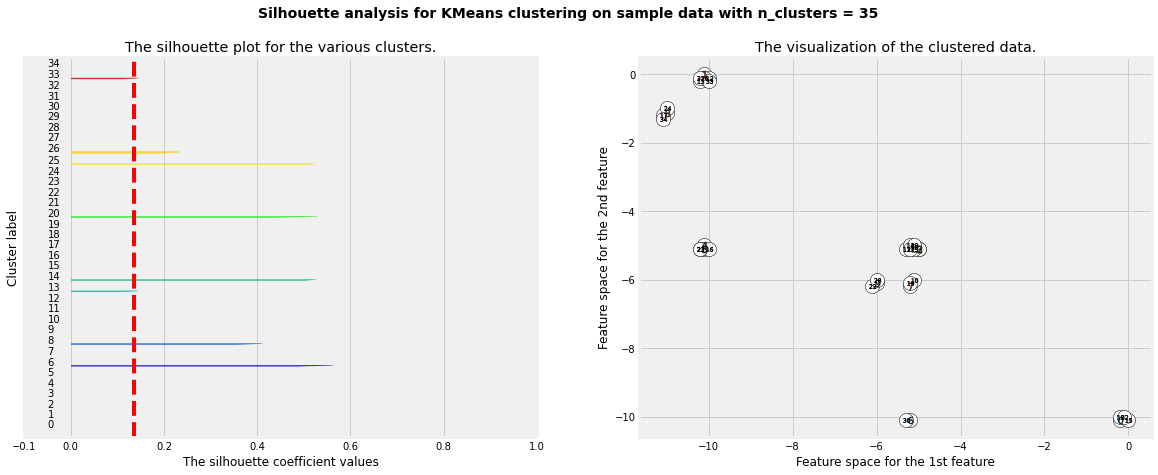

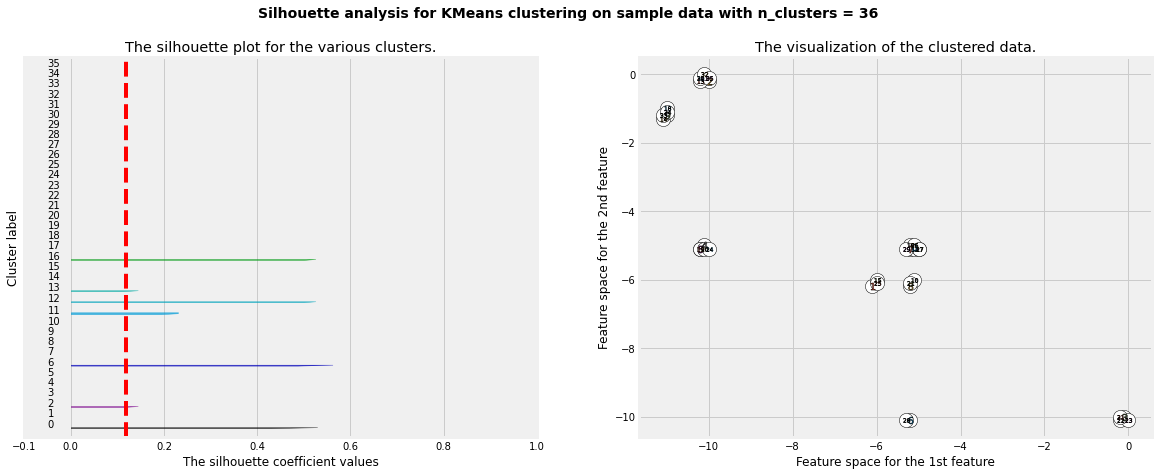

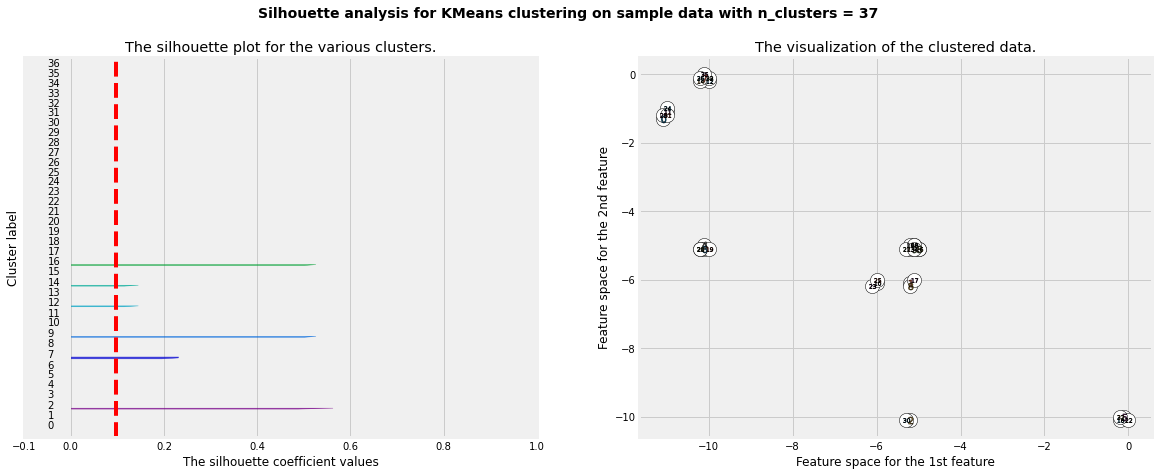

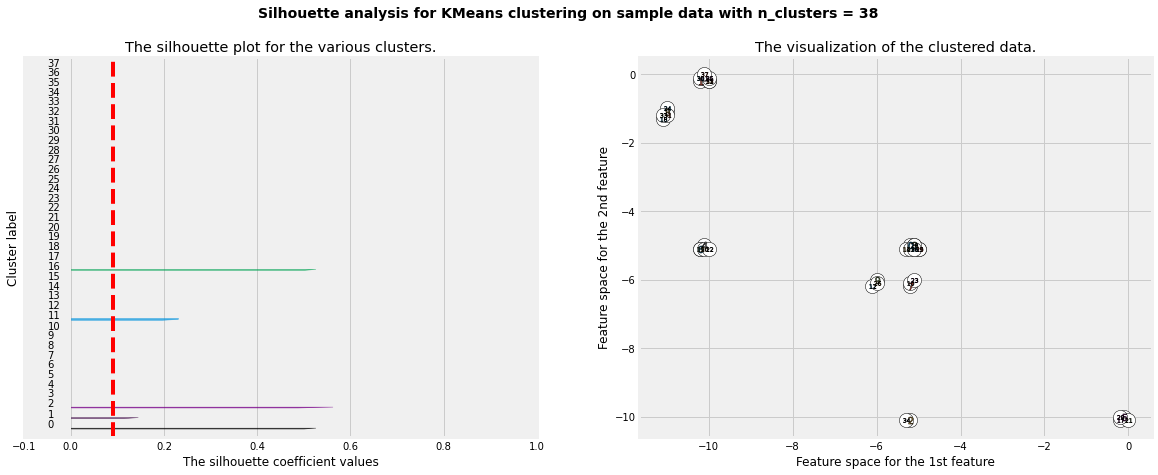

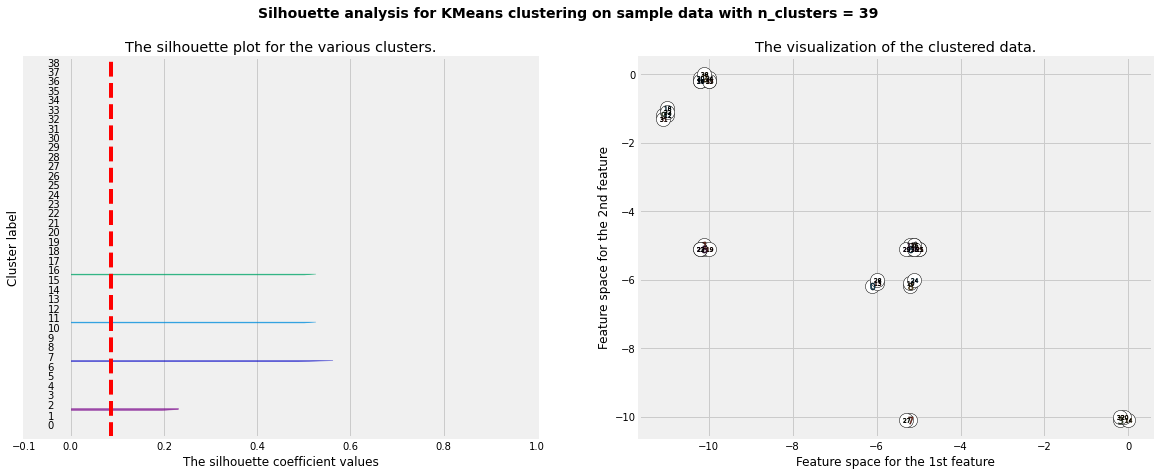

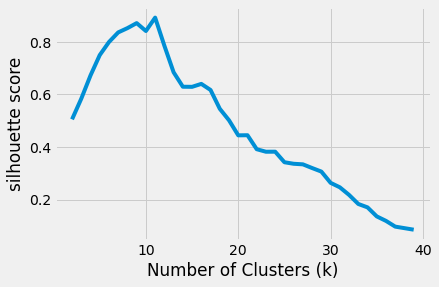

In [12]:

'''measure the silhouette coefficients to find the optimal cluster size'''

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

range_n_clusters = range(2, 40)
silhouette_avg_n_clusters = []
unique_seq_list = df['Compact_Sequence'].value_counts().loc[lambda x : x>=CFG.MIN_COUNT].index.to_list()
unique_seq_list = list(set(unique_seq_list))

unique_seq_list = [x for x in unique_seq_list if len(x) > CFG.MIN_SEQUENCE]

X = lev_similarity(unique_seq_list, unique_seq_list)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

In [13]:
# Finding the first peak in silhouette scores
optimal_n_clusters = None
for i in range(1, len(silhouette_avg_n_clusters) - 1):
    if silhouette_avg_n_clusters[i] > silhouette_avg_n_clusters[i - 1] and silhouette_avg_n_clusters[i] > silhouette_avg_n_clusters[i + 1]:
        optimal_n_clusters = range_n_clusters[i]
        break

print("Optimal number of clusters (first peak):", optimal_n_clusters)

Optimal number of clusters (first peak): 9


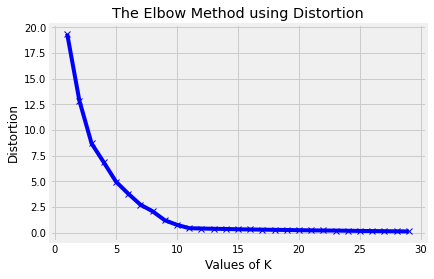

Optimal number of clusters (elbow method): 9


In [14]:
'''elbow method for determining max number of clusters based on this method'''

%matplotlib inline
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the distance between a point and a line
def calculate_distance(point, line_start, line_end):
    x0, y0 = point
    x1, y1 = line_start
    x2, y2 = line_end
    return np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

distortions = []
K = range(1, 30)

X = lev_similarity(unique_seq_list, unique_seq_list)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plotting the distortions
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# Identifying the elbow point
max_distance = 0
elbow_k = None

line_start = (K[0], distortions[0])
line_end = (K[-1], distortions[-1])

for k, distortion in zip(K, distortions):
    distance = calculate_distance((k, distortion), line_start, line_end)
    if distance > max_distance:
        max_distance = distance
        elbow_k = k

print("Optimal number of clusters (elbow method):", elbow_k)


In [15]:

'''use optimal cluster size to assign cluster values based on above results from silhouette score
although elbow could also be used if you change elbow_k'''



NUM_CLUSTERS=optimal_n_clusters #change to elbow_k if you want to use elbow's opimal clusters
cluster_dict = {}




#create a dictionary of all labels matched to clusters in original array
def make_kmeans_dict(labels, source_array):

    labels_dict = {}

    for i, label in enumerate(labels):
        labels_dict[source_array[i]] = label
    
    return labels_dict

#create a dictionary of all clusters matched to all labels matched to clusters in original array
def make_cluster_dict(labels, source_array):

    cluster_dict = {}

    for i, label in enumerate(labels):
        if label not in cluster_dict:
#             print(label)
            cluster_dict[label]=[source_array[i]]
        else:
#             print('here')
            cluster_dict[label].append(source_array[i])
#             print(cluster_dict[label])
        
    
    return cluster_dict


KM = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
KM.fit(lev_similarity(unique_seq_list, unique_seq_list), )

compact_unique_seq = list(df['Compact_Sequence'].unique())

matrix = lev_similarity(unique_seq_list, compact_unique_seq)

labels = KM.predict(matrix)

row_dict = {}
clusters = {}


labels_dict = make_kmeans_dict(labels, compact_unique_seq)
cluster_dict = make_cluster_dict(labels, compact_unique_seq)

df[f'cluster_id'] = [labels_dict[x] for x in df['Compact_Sequence']]

In [16]:
'''Sequences are assigned the appropriate Cluster ID in the cluster_id column'''

df.head()


,Sequence_ID,Compact_Sequence,cluster_id
0,0,axx,0
1,1,oxx,2
2,2,axx,0
3,3,oxx,2
4,4,kxx,1
